In [75]:
import pandas as pd
import uproot as ur
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn


from torch.utils.data import Dataset , DataLoader

In [76]:
# N_output -> number of inputs variables
N_layer1 = 32
N_layer2 = 32
N_layer3 = 32
N_layer4 = 25

do_dropout = True
Drop_rate = 0.2

In [77]:
file = pd.read_csv('./fracdata.csv',' ')

#df = file.arrays(library="pd")
df1 = file.head(150000)
#df1.columns
df1.keys()

/tmp/ipykernel_101864/3758685766.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  file = pd.read_csv('./fracdata.csv',' ')


Index(['seqNumber', 'runNumber', 'eventNumber', 'avgMu', 'nPrimVtx', 'jetCnt',
       'jetCalE', 'jetCalPt', 'jetCalEta', 'jetCalPhi', 'jetRawE', 'jetRawPt',
       'jetRawEta', 'jetRawPhi', 'jetNConst', 'truthJetMatchRadius',
       'truthJetE', 'truthJetPt', 'truthJetRap', 'truthJetPhi', 'nCluster',
       'clusterIndex', 'cluster_nCells', 'cluster_nCells_tot', 'clusterECalib',
       'clusterPtCalib', 'clusterEtaCalib', 'clusterPhiCalib',
       'cluster_sumCellECalib', 'cluster_fracECalib', 'cluster_fracECalib_ref',
       'clusterE', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_sumCellE',
       'cluster_time', 'cluster_fracE', 'cluster_fracE_ref',
       'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_OOC_WEIGHT',
       'cluster_DM_WEIGHT', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T',
       'cluster_ENG_CALIB_OUT_L', 'cluster_ENG_CALIB_OUT_M',
       'cluster_ENG_CALIB_DEAD_T', 'cluster_ENG_CALIB_DEAD_L',
       'cluster_ENG_CALIB_DEAD_M', 'cluster_ENG_CALI

In [78]:
#for event in eventNumbers:
tempE = []
tempEta = []
temp_time = []
temp_labels = []
count_jets = 1
old_event = df1['jetCnt'][0]
old_jetCnt = df1['jetCnt'][0]
change_bol = False

clusterE = []
clusterEta = []
cluster_time = []
cluster_CENTER_LAMBDA = []
cluster_CENTER_MAG = []
clusterPhi = []

labels = []

for index,row in df1.iterrows():
    
    clusterE.append(row['clusterE'])
    clusterEta.append(row['clusterEtaCalib'])
    cluster_time.append(row['cluster_time']/10)
    labels.append( int(row['cluster_ENG_CALIB_TOT'] <= 0) )
    cluster_CENTER_LAMBDA.append(row['cluster_CENTER_LAMBDA']/100)
    cluster_CENTER_MAG.append(row['cluster_CENTER_MAG']/1000)
    clusterPhi.append(row['clusterPhi'])

In [79]:
## create Dictionary containing data and labels

Dictionary_data ={
    "0": clusterE,
    "1": clusterEta,
    "2": cluster_time,
    "3": cluster_CENTER_LAMBDA,
    "4": cluster_CENTER_MAG,
#    "5": clusterPhi,
    "label": labels
}

In [80]:
len(Dictionary_data["2"])

150000

In [81]:
# Let's go to use an simple Neural Network :3 :3 :3
class NN_pileup(nn.Module):
    def __init__(self):
        super(NN_pileup,self).__init__()

        self.Drop = nn.Dropout( Drop_rate ) #0.25 debo testear esto hasta encontrar lo mejor!!!
        
        self.layer1 = nn.Linear(len(Dictionary_data)-1 ,N_layer1)   
        self.layer2 = nn.Linear(N_layer1,N_layer2) 
        self.layer3 = nn.Linear(N_layer2,N_layer3) 
        self.layer4 = nn.Linear(N_layer3,1) 
        #self.layer5 = nn.Linear(N_layer4,1)  
        
        self.activationReLU = nn.ReLU()
        self.activationLeaky = nn.LeakyReLU()
        self.activation = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def  forward(self,x): #"pass the input through each of our operators"
        x = self.layer1(x)
        x = self.activationReLU(x)
        if do_dropout ==True:
            x = self.Drop(x)   ###!!!!!!!!!!!!
        
        x = self.layer2(x)
        x = self.activationReLU(x)
        if do_dropout ==True:
            x = self.Drop(x)   ###!!!!!!!!!!!!
        
        x = self.layer3(x)
        x = self.activationReLU(x)

        if do_dropout ==True:
            x = self.Drop(x)   ###!!!!!!!!!!!!
        
        x = self.layer4(x)
        '''
        x = self.activationReLU(x)
        if do_dropout ==True:
            x = self.Drop(x)   ###!!!!!!!!!!!!
        
        x = self.layer5(x)
        '''
        x = nn.functional.sigmoid(x)
        
        return x

In [82]:
class MyDataSet_train(torch.utils.data.Dataset):
    def __init__(self, Dictionary_data):
    
        #self.filename = filename
        self.EM14 = 1
        
    def __len__(self):
        return len(Dictionary_data["1"])
    
    def __getitem__(self, idx):

        features = []
        
        for i in range (0,len(Dictionary_data)-1):
            features.append(Dictionary_data[str(i)][idx])
            #print(len(features) )
            
        return np.array(features,dtype="float32" ), np.array( Dictionary_data["label"][idx],dtype="float32" )



In [83]:
Data_train = MyDataSet_train( Dictionary_data )

Batch_number = 1024*6

Data_train[26]

(array([1.6889977, 0.7223266, 1.672847 , 0.6375   , 1.968    ],
       dtype=float32),
 array(0., dtype=float32))

In [84]:
size_train = 0.2

from sklearn.model_selection import train_test_split


Data_train,Data_test = train_test_split(Data_train, test_size = size_train, random_state = 14)


In [85]:
len(Data_train)

120000

In [86]:
len(Data_test)

30000

In [103]:
#train_loader = DataLoader(Data_train,batch_size=Batch_number, shuffle=True,num_workers = 3)
train_loader = DataLoader(Data_train,batch_size=Batch_number, shuffle=True)
test_loader = DataLoader(Data_test,batch_size=Batch_number, shuffle=True)


model = NN_pileup()

Adam_weight_decay = 0.002
learning_ratio = 0.001

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_ratio , weight_decay=Adam_weight_decay ) 
criterion = nn.CrossEntropyLoss()


#torch.nn.functional.binary_cross_entropy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [104]:
model.train()
epoch_loss=0
num_epochs= 40
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for data in train_loader:
        #data = data.to(device)
        #print(data[0])
        model.train()
        
        optimizer.zero_grad()
        out = model(data[0])
        out = out.view(-1, out.shape[-1])
        
        #labels = torch.tensor(data.y, dtype=torch.long).to(device) 
        labels = data[1]
        #print(out.shape)
        #print(labels.shape)
        
        labels = torch.reshape(labels, (int(list(labels.shape)[0]),1))
        #loss = criterion(out, labels)
        loss = torch.nn.functional.binary_cross_entropy(out, labels)
        #print(loss)
        loss.backward()
        optimizer.step()
        
        
        
        epoch_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss_train: {epoch_loss:.4f}')

    
    epoch_loss = 0.0
    nodes_out = torch.tensor([])
    labels_test = torch.tensor([])
    if (epoch+1)%5==0:
        for data in train_loader:
            model.eval()
            #data = data.to(device)  # Move batch data to the same device as model
            out = model(data[0])
            out = out.view(-1, out.shape[-1])
            labels = data[1] 
            labels = torch.reshape(labels, (int(list(labels.shape)[0]),1))
            loss = torch.nn.functional.binary_cross_entropy(out, labels)
    
            nodes_out = torch.cat((nodes_out, out), 0)
            labels_test = torch.cat((labels_test, labels), 0)    
    
            epoch_loss += loss.item()
        model.train()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss_test: {epoch_loss:.4f}')


Epoch [1/40], Loss_train: 10.8983
Epoch [2/40], Loss_train: 8.2829
Epoch [3/40], Loss_train: 7.4509
Epoch [4/40], Loss_train: 7.1436
Epoch [5/40], Loss_train: 7.0699
Epoch [5/40], Loss_test: 7.0558
Epoch [6/40], Loss_train: 7.4546
Epoch [7/40], Loss_train: 7.0332
Epoch [8/40], Loss_train: 7.0155
Epoch [9/40], Loss_train: 7.0124
Epoch [10/40], Loss_train: 7.0044
Epoch [10/40], Loss_test: 7.0091
Epoch [11/40], Loss_train: 7.3830
Epoch [12/40], Loss_train: 7.0023
Epoch [13/40], Loss_train: 6.9858
Epoch [14/40], Loss_train: 6.9744
Epoch [15/40], Loss_train: 6.9663
Epoch [15/40], Loss_test: 6.9702
Epoch [16/40], Loss_train: 7.3078
Epoch [17/40], Loss_train: 6.9777
Epoch [18/40], Loss_train: 6.9482
Epoch [19/40], Loss_train: 6.9326
Epoch [20/40], Loss_train: 6.9304
Epoch [20/40], Loss_test: 6.9271
Epoch [21/40], Loss_train: 7.2821
Epoch [22/40], Loss_train: 6.9280
Epoch [23/40], Loss_train: 6.9155
Epoch [24/40], Loss_train: 6.8917
Epoch [25/40], Loss_train: 6.8977
Epoch [25/40], Loss_test: 6

In [105]:
epoch_loss = 0.0
model.eval()
nodes_out = torch.tensor([])
labels_test = torch.tensor([])
#for data in train_loader:
for data in test_loader:

    #data = data.to(device)  # Move batch data to the same device as model
    out = model(data[0])
    out = out.view(-1, out.shape[-1])
    labels = data[1] 
    labels = torch.reshape(labels, (int(list(labels.shape)[0]),1))
    loss = torch.nn.functional.binary_cross_entropy(out, labels)
    
    nodes_out = torch.cat((nodes_out, out), 0)
    labels_test = torch.cat((labels_test, labels), 0)    
    
    epoch_loss += loss.item()
model.train()
print(f'Epoch [{epoch+1}/{num_epochs}], Loss_test: {epoch_loss:.4f}')

Epoch [40/40], Loss_test: 1.7062


In [106]:
#Epoch [40/40], Loss: 6.5864
#Epoch [32/32], Loss: 6.4953

In [107]:
len(nodes_out[labels_test<0.5])

26186

In [108]:
print("mean Pileup->",torch.mean(nodes_out[labels_test>0.5]), "\n" , "mean NoPileup->",torch.mean(nodes_out[labels_test<0.5]))

mean Pileup-> tensor(0.2032, grad_fn=<MeanBackward0>) 
 mean NoPileup-> tensor(0.1228, grad_fn=<MeanBackward0>)


In [109]:
def VecROC(VEC):
    VEC_sum=0
    bkg_sum=0
    VEC_out = np.zeros(len(VEC))
    #for i in range (len(VEC)-1,-1,-1 ):
    for i in range (0,len(VEC),1 ):
        VEC_sum += VEC[i]
        #VEC_out.append(VEC_sum) 
        VEC_out[i] = VEC_sum
    return VEC_out/VEC_sum

number_bins = 100

out_NoPile = nodes_out[labels_test<0.5].detach().numpy()
out_Pile = nodes_out[labels_test>0.5].detach().numpy()

hist_NoPile = np.histogram( out_NoPile , bins=number_bins , range=(0,1) )#, weights = weight_good  )
hist_Pile = np.histogram( out_Pile , bins=number_bins , range=(0,1) )

In [110]:
#hist_NoPile
#hist_Pile

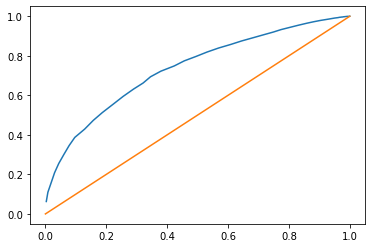

In [111]:
import matplotlib.pyplot as plt
ROC_NoPile = VecROC(hist_NoPile[0])
ROC_Pile = VecROC(hist_Pile[0])
fig, ax = plt.subplots()
ax.plot(ROC_Pile, ROC_NoPile)
ax.plot([0.0, 1.0], [0.0, 1.0])
plt.show()
## using test data

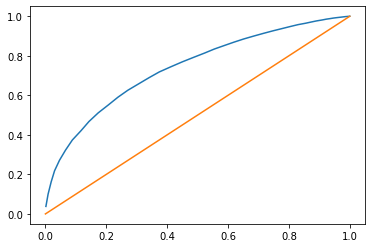

In [270]:
import matplotlib.pyplot as plt
ROC_NoPile = VecROC(hist_NoPile[0])
ROC_Pile = VecROC(hist_Pile[0])
fig, ax = plt.subplots()
ax.plot(ROC_Pile, ROC_NoPile)
ax.plot([0.0, 1.0], [0.0, 1.0])
plt.show()
## using train data

In [256]:
bb = np.array([1,2.2])
print(bb.dtype)
print( (bb.astype("float32")).dtype )
print(bb.dtype)


float64
float32
float64
